<p style="font-size:3em"> Implement a scoring model</p>

<br/>

This notebook corresponds to the scoring model part of the **7th project of my data scientist path** with **OpenClassrooms/CentralSupelec** 

This project aims to provide the necessary skills on imbalanced data handling and dashboard/api creation

This notebook uses a preprocessed data from a Kaggle Kernel so as to train and select a model which handles imbalanced data for prediction :<br>

* Overview imbalanced data
* Stratified split for tests
* Overview of different imbalance management methods (Undersampling, SMOTE, Sample Weights, Proba Threshold Management)
* Model Interpretability with SHAP
                 
___ 
<b>I strongly recommend to use the 'table of content' extension of Jupyter to navigate through this notebook </b>

# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import time

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from bayes_opt import BayesianOptimization


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,ParameterGrid, cross_validate

from sklearn.ensemble import RandomForestClassifier
from  xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score,roc_auc_score,confusion_matrix,recall_score,precision_score,accuracy_score


In [62]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [50]:
data = pd.read_csv('data.csv')

In [170]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
# Fit on the training data
imputer.fit(data)

# Transform both training and testing data
data = pd.DataFrame(imputer.transform(data),columns=data.columns)

In [16]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,100003.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,100004.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.shape

(307511, 241)

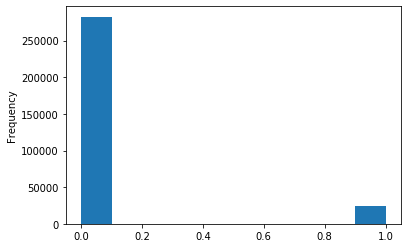

In [6]:
plt.figure(figsize=(12,8))
plt.title('Distibution of ')

data['TARGET'].astype(int).plot.hist()


___
Here we can see a consequent imbalance between class 1 (low percentage of the data) and class 0 (very high percentage of the data)

In [12]:
pie_data = pd.DataFrame(data['TARGET'].value_counts())
pie_data

,TARGET
0,282686
1,24825


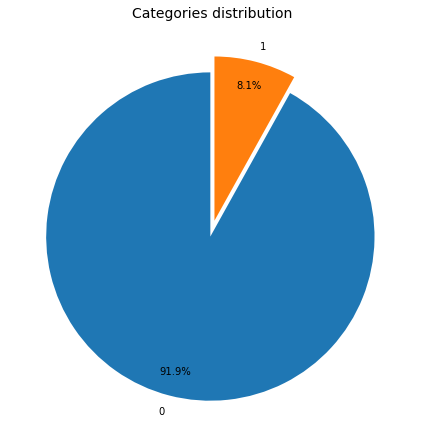

In [15]:
labels = pie_data.index
sizes = pie_data.TARGET

#explsion
explode = [0.05]*pie_data.shape[0]

plt.figure(figsize=[10,6])
plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

 
plt.tight_layout()
plt.title('Categories distribution',fontsize=14)
plt.show()

# Split Data

We need to split the data to prepare the training of our models : 
    
   * Train Set -> 60% of the initial dataset to train the models
   * Validation Set -> 20% of the initial dataset to evaluate models score and select the best
   * Test Set -> 20% of the initial dataset as a final test of the selected model with unknown data

In [51]:
# Split train_test with keeping the categories distribution

train,test = train_test_split(data,
                              test_size=0.20,
                              stratify=data['TARGET'])

   TARGET
0   56538
1    4965


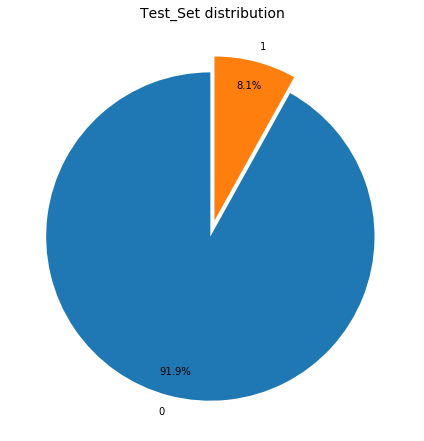

In [20]:
pie_data = pd.DataFrame(test['TARGET'].value_counts())
print(pie_data)

labels = pie_data.index
sizes = pie_data.TARGET

#explsion
explode = [0.05]*pie_data.shape[0]

plt.figure(figsize=[10,6])
plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

 
plt.tight_layout()
plt.title('Test_Set distribution',fontsize=14)
plt.show()

In [52]:
train,validation = train_test_split(train,
                                    test_size=0.25,
                                    stratify=train['TARGET'])

   TARGET
0  113074
1    9930


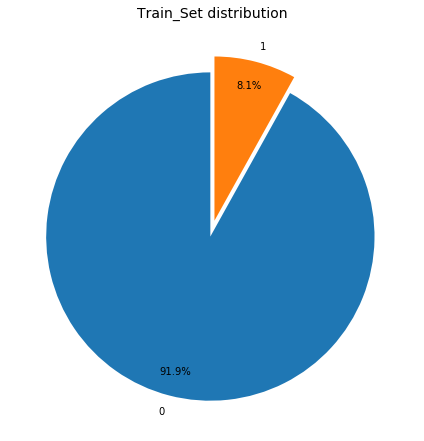

In [21]:
pie_data = pd.DataFrame(train['TARGET'].value_counts())
print(pie_data)

labels = pie_data.index
sizes = pie_data.TARGET

#explsion
explode = [0.05]*pie_data.shape[0]

plt.figure(figsize=[10,6])
plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

 
plt.tight_layout()
plt.title('Train_Set distribution',fontsize=14)
plt.show()

   TARGET
0   56537
1    4965


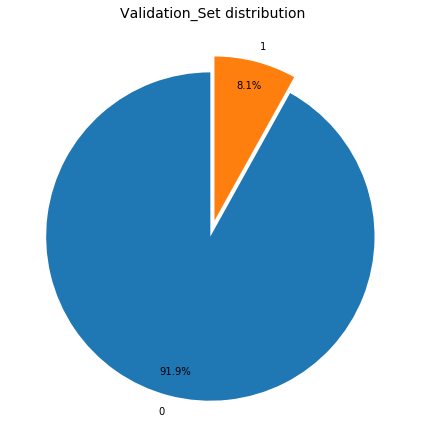

In [53]:
pie_data = pd.DataFrame(validation['TARGET'].value_counts())
print(pie_data)

labels = pie_data.index
sizes = pie_data.TARGET

#explsion
explode = [0.05]*pie_data.shape[0]

plt.figure(figsize=[10,6])
plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

 
plt.tight_layout()
plt.title('Validation_Set distribution',fontsize=14)
plt.show()

In [173]:
train.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_7\train2.csv', index = False, header=True)
validation.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_7\validation2.csv', index = False, header=True)
test.to_csv (r'C:\Users\quent\Desktop\Formation_OCR\Projets\Projet_7\test2.csv', index = False, header=True)

# Observ scoring 

Here we decided to use the Fbeta Score : 

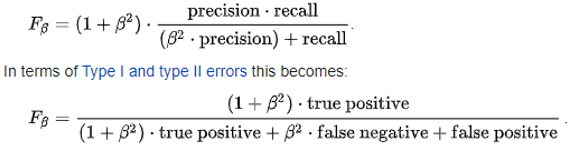

After a few attempts Beta has been setup with the value 3, let's observe the behaviour of the score with this setup

In [152]:
s = pd.Series([0, 1])

In [153]:
# Create a list with 50 sample of category_0 and 50 samples of category_1 
s=s.repeat(50)
s.shape

(100,)

In [155]:
s_predi = s.copy()

## Perfect score

Accuracy: 1.0
 Precision: 1.0
 Recall: 1.0
 Fbeta(3): 1.0



C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass beta=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


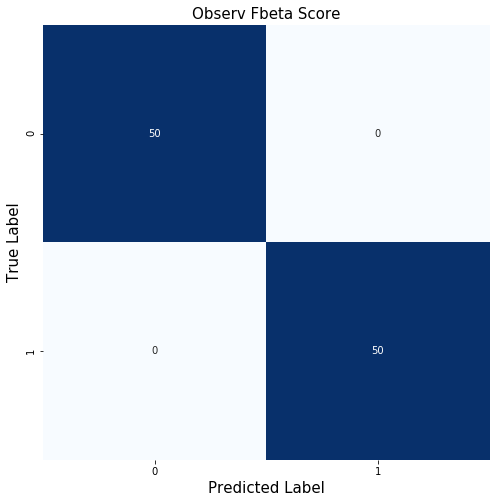

In [157]:
# Print Confusion Matrix (Perfect Score - Accuracy 100%)

accu = accuracy_score(s,s_predi)
prec = precision_score(s,s_predi)
rec = recall_score(s,s_predi)
fbeta = fbeta_score(s,s_predi,3)

print('Accuracy: {}\n Precision: {}\n Recall: {}\n Fbeta(3): {}\n'.format(accu,prec,rec,fbeta))

cm = confusion_matrix(s,
                      s_predi)

plt.figure(figsize=(8,8))
plt.title('Observ Fbeta Score',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)
plt.show()

## Reduce Precision score

First let's observe the scores (accuracy, recall, precision, fbeta(3)) with increasing the false negative by 10

In [158]:
s_predi

0    0
0    0
0    0
0    0
0    0
    ..
1    1
1    1
1    1
1    1
1    1
Length: 100, dtype: int64

In [165]:
s_predi_2 = s_predi.copy()
for i in range(10):
    s_predi_2.iloc[i]=1
s_predi_2

0    1
0    1
0    1
0    1
0    1
    ..
1    1
1    1
1    1
1    1
1    1
Length: 100, dtype: int64

Accuracy: 0.9
Precision: 0.8333333333333334
Recall: 1.0
Fbeta(3): 0.9803921568627452



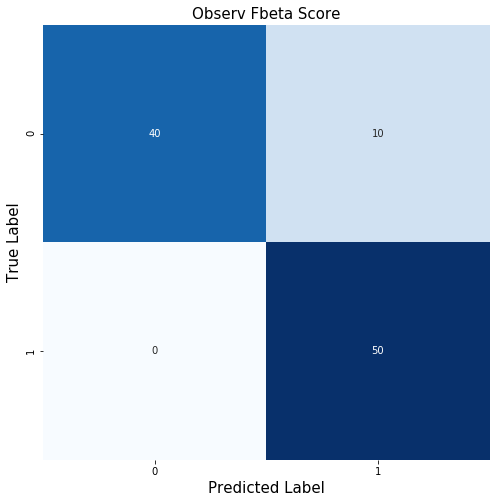

In [167]:
# Print Confusion Matrix 

accu = accuracy_score(s,s_predi_2)
prec = precision_score(s,s_predi_2)
rec = recall_score(s,s_predi_2)
fbeta = fbeta_score(s,s_predi_2,3)

print('Accuracy: {}\nPrecision: {}\nRecall: {}\nFbeta(3): {}\n'.format(accu,prec,rec,fbeta))

cm = confusion_matrix(s,
                      s_predi_2)

plt.figure(figsize=(8,8))
plt.title('Observ Fbeta Score',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)
plt.show()

## Reduce Precision score

Now let's observe the scores (accuracy, recall, precision, fbeta(3)) with increasing the false negative by 10

In [158]:
s_predi

0    0
0    0
0    0
0    0
0    0
    ..
1    1
1    1
1    1
1    1
1    1
Length: 100, dtype: int64

In [162]:
s_predi_2 = s_predi.copy()
for i in range(1,11):
    s_predi_2.iloc[-i]=0
s_predi_2

0    0
0    0
0    0
0    0
0    0
    ..
1    0
1    0
1    0
1    0
1    0
Length: 100, dtype: int64

Accuracy: 0.9
Precision: 1.0
Recall: 0.8
Fbeta(3): 0.8163265306122448



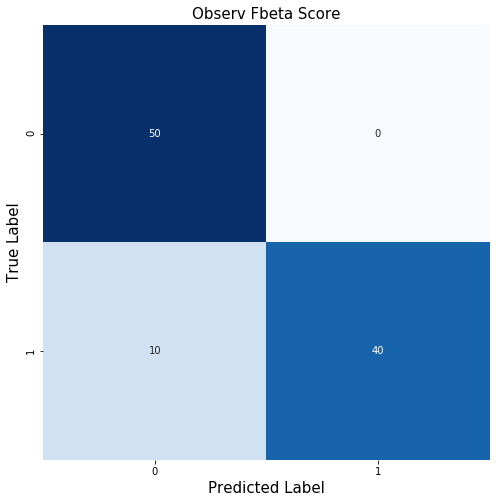

In [164]:
# Print Confusion Matrix 

accu = accuracy_score(s,s_predi_2)
prec = precision_score(s,s_predi_2)
rec = recall_score(s,s_predi_2)
fbeta = fbeta_score(s,s_predi_2,3)

print('Accuracy: {}\nPrecision: {}\nRecall: {}\nFbeta(3): {}\n'.format(accu,prec,rec,fbeta))

cm = confusion_matrix(s,
                      s_predi_2)

plt.figure(figsize=(8,8))
plt.title('Observ Fbeta Score',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)
plt.show()

Here we can spot the difference of impact between false positives and false negatives on the final Fbeta score 

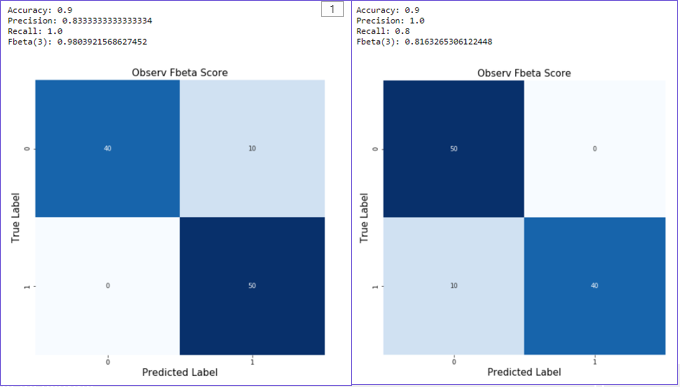

# Train and select model

Let's train and select a few models with different imbalance management methods

In [71]:
train = pd.read_csv('train.csv')
val = pd.read_csv('validation2.csv')
test = pd.read_csv('test2.csv')

In [72]:
y_train = np.array(train.TARGET)
train.drop(['TARGET'], axis = 1, inplace = True)
X_train = train.values

In [73]:
y_val = np.array(val.TARGET)
val.drop(['TARGET'], axis = 1, inplace = True)
X_val = val.values

In [450]:
summary_imbalance=pd.DataFrame(columns=['f_beta_score','best_param'])

In [324]:
models = {}

## Baseline 

In [74]:
std = StandardScaler()
scaled_train = std.fit_transform(X_train)
scaled_val = std.transform(X_val)

In [453]:
parameters = {
              "min_samples_leaf":[1,3,5,7],
              "max_depth": [int(i) for i in np.linspace(5, 30, num = 4)],
              "max_features":['auto', 'sqrt']
             } 

#Create a param grid with each combination of the above declared hyperparameters
params=ParameterGrid(parameters)

import time
print('Param Optimisation start\n________________')
print('{} Steps to be done'.format(len(params)))
now = time.asctime()
print(now,'\n')

best_score = 0
best_model = None
best_params = None
best_predi = None
count=0

# Loop for each combination of parameters
for param in params:
    

    
    rdm = RandomForestClassifier(n_estimators= 200,
                                 min_samples_leaf=param['min_samples_leaf'],
                                 max_depth=param['max_depth'],
                                 max_features=param['max_features'])
    

    rdm.fit(scaled_train,y_train)
    
    y_pred = rdm.predict(scaled_val)
    
    score = fbeta_score(y_val, y_pred, beta=3)
    
    # Evaluate Fbeta score, only keeps the highest score
    
    if score > best_score:
        best_score = score
        best_model = rdm
        best_param = str(param)
        best_predi = y_pred
        
    
    if count % 10 == 0 : 
        print('Step {} done\n'.format(count))
        now = time.asctime()
        print(now,'\n')
        
    count+=1
    
    
#Write score in summary table
summary_imbalance.loc['Baseline ','f_beta_score']=best_score

#Write the string form of the best params dict
summary_imbalance.loc['Baseline ','best_param']=best_param
# summary_imbalance
models['Baseline']= best_model
predi = best_predi

Param Optimisation start
________________
32 Steps to be done
Tue Nov 17 18:01:16 2020 

Step 0 done

Tue Nov 17 18:01:40 2020 

Step 10 done

Tue Nov 17 18:08:09 2020 

Step 20 done

Tue Nov 17 18:22:36 2020 

Step 30 done

Tue Nov 17 18:41:11 2020 



Text(0.5, 51.0, 'Predicted Label')

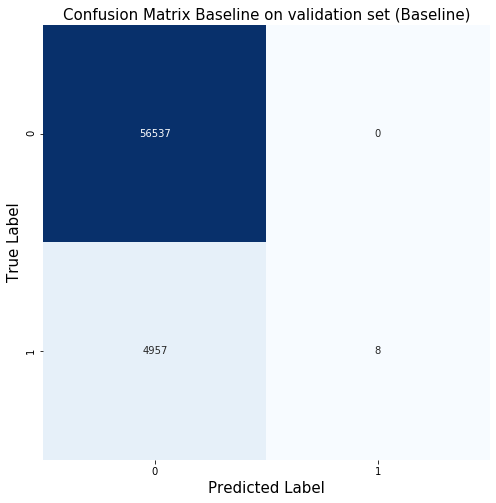

In [454]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      y_pred)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Baseline on validation set (Baseline)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

## Baseline With Threshold

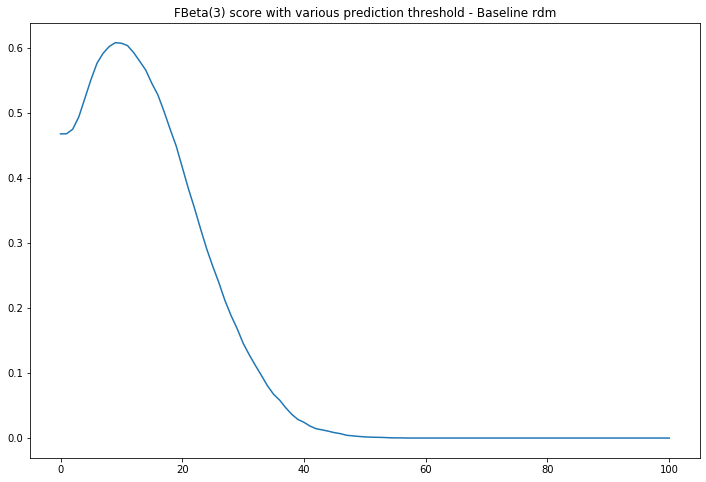

In [456]:
# Create a lineplot showing the evolution of the fbeta score 
# with changing the threshold proba for class_1

score_threshold=[]
predi = rdm.predict_proba(scaled_val)
for i in range(101):
    y_pred = (predi[:,1] >= i/100).astype(bool) # set threshold 
    score = fbeta_score(y_val, y_pred, beta=3)
    score_threshold.append(score)

plt.figure(figsize=(12,8))
plt.title('FBeta(3) score with various prediction threshold - Baseline rdm')
sns.lineplot(list(range(101)),score_threshold)


In [457]:
# Save the threshold with highest score
threshold=[i for i, j in enumerate(score_threshold) if j == max(score_threshold)][-1]/100
threshold

0.09

In [458]:
# Save prediction with the best threshold
max_predi = (rdm.predict_proba(scaled_val)[:,1] >=threshold) .astype(bool)

In [459]:
# Save score and params
summary_imbalance.loc['Baseline (Proba Threshold)','f_beta_score']=max(score_threshold)
my_param = eval(best_param)
my_param['threshold_proba']=threshold
summary_imbalance.loc['Baseline (Proba Threshold)','best_param']=str(my_param)

Text(0.5, 51.0, 'Predicted Label')

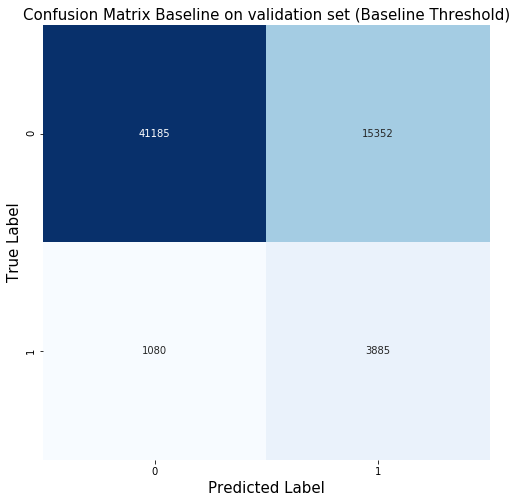

In [460]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      max_predi)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Baseline on validation set (Baseline Threshold)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

In [461]:
summary_imbalance

,f_beta_score,best_param
Baseline,0.337953,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Baseline (Proba Threshold),0.607772,"{'max_depth': 30, 'max_features': 'auto', 'min..."


## Undersampling

In [462]:
rus = RandomUnderSampler(random_state=0)
x_under, y_under =rus.fit_sample(X_train, y_train)

In [463]:
std = StandardScaler()
scaled_train = std.fit_transform(x_under)
scaled_val = std.transform(X_val)

In [464]:
parameters = {
              "min_samples_leaf":[1,3,5,7],
              "max_depth": [int(i) for i in np.linspace(5, 30, num = 4)],
              "max_features":['auto', 'sqrt']
             } 


params=ParameterGrid(parameters)

import time
print('Param Optimisation start\n________________')
print('{} Steps to be done'.format(len(params)))
now = time.asctime()
print(now,'\n')

best_score = 0
best_model = None
best_params = None
best_predi = None
count=0

for param in params:
    

    
    rdm = RandomForestClassifier(n_estimators= 200,
                                 min_samples_leaf=param['min_samples_leaf'],
                                 max_depth=param['max_depth'],
                                 max_features=param['max_features'])
    

    rdm.fit(scaled_train,y_under)
    
    y_pred = rdm.predict(scaled_val)
    
    score = fbeta_score(y_val, y_pred , beta=3)
    
    if score > best_score:
        best_score = score
        best_model = rdm
        best_param = str(param)
        best_predi = y_pred
        
    
    if count % 10 == 0 : 
        print('Step {} done\n'.format(count))
        now = time.asctime()
        print(now,'\n')
        
    count+=1
    
    
#Write score in summary table
summary_imbalance.loc['Undersampling ','f_beta_score']=best_score

#Write the string form of the best params dict
summary_imbalance.loc['Undersampling ','best_param']=best_param
# summary_imbalance
models['Undersampling']= best_model

Param Optimisation start
________________
32 Steps to be done
Tue Nov 17 18:43:16 2020 

Step 0 done

Tue Nov 17 18:43:21 2020 

Step 10 done

Tue Nov 17 18:44:32 2020 

Step 20 done

Tue Nov 17 18:46:36 2020 

Step 30 done

Tue Nov 17 18:49:13 2020 



In [465]:
best_score

0.598514434489624

Text(0.5, 51.0, 'Predicted Label')

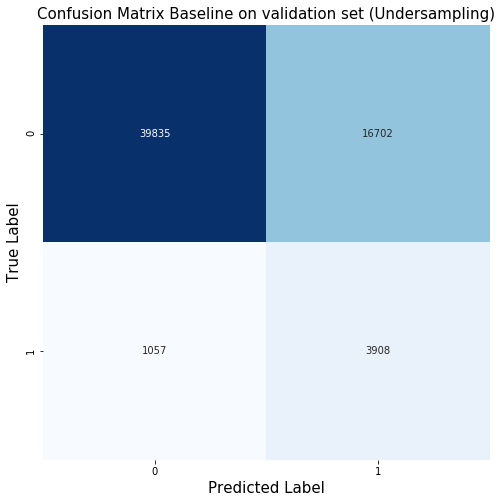

In [466]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      best_predi)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Baseline on validation set (Undersampling)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

### Undersampling with Threshold

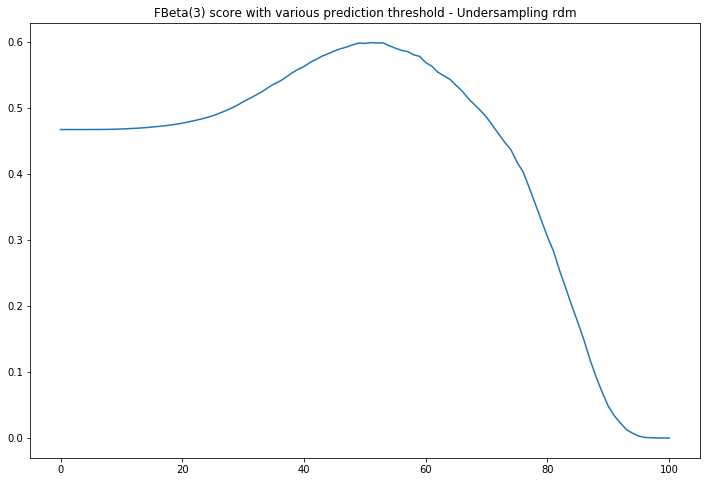

In [467]:
score_threshold=[]
predi = best_model.predict_proba(scaled_val)
for i in range(101):
    y_pred = (predi[:,1] >= i/100).astype(bool) # set threshold 
    score = fbeta_score(y_val, y_pred, beta=3)
    score_threshold.append(score)

plt.figure(figsize=(12,8))
plt.title('FBeta(3) score with various prediction threshold - Undersampling rdm')
sns.lineplot(list(range(101)),score_threshold)


In [468]:
threshold=[i for i, j in enumerate(score_threshold) if j == max(score_threshold)][-1]/100
threshold

0.51

In [469]:
max_predi = (best_model.predict_proba(scaled_val)[:,1] >=threshold) .astype(bool)

In [470]:
summary_imbalance.loc['Undersampling (Proba Threshold)','f_beta_score']=max(score_threshold)
my_param = eval(best_param)
my_param['threshold_proba']=threshold
summary_imbalance.loc['Undersampling (Proba Threshold)','best_param']=str(my_param)

Text(0.5, 51.0, 'Predicted Label')

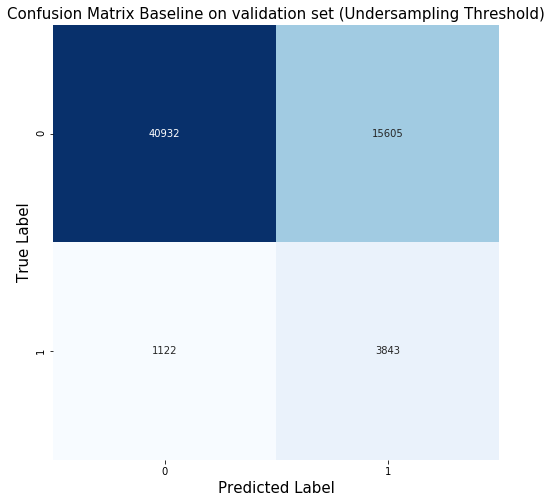

In [471]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      max_predi)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Baseline on validation set (Undersampling Threshold)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

In [472]:
summary_imbalance

,f_beta_score,best_param
Baseline,0.337953,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Baseline (Proba Threshold),0.607772,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Undersampling,0.598514,"{'max_depth': 30, 'max_features': 'sqrt', 'min..."
Undersampling (Proba Threshold),0.599223,"{'max_depth': 30, 'max_features': 'sqrt', 'min..."


## SMOTE

### SMOTE Method overview 

Let's observe SMOTE behaviour with a simple example

In [52]:
sig = 4
mu1 = 10
mu2 = 30

gauss1 = pd.DataFrame(np.random.multivariate_normal((mu1,mu1),([sig,0],[0,sig]) , 10000), columns=['D1','D2'])
gauss2 = pd.DataFrame(np.random.multivariate_normal((mu2,mu2),([sig,0],[0,sig]) , 1000), columns=['D1','D2'])

gauss1['categ']='0'
gauss2['categ']='1'


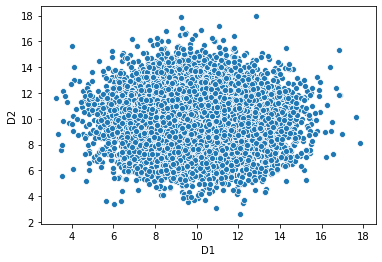

In [53]:
sns.scatterplot(gauss1.D1,gauss1.D2)

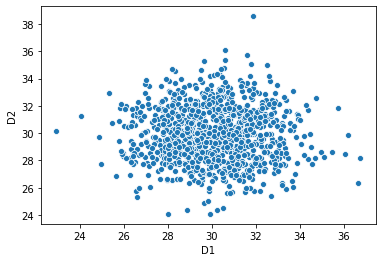

In [54]:
sns.scatterplot(gauss2.D1,gauss2.D2)

In [55]:
overview1 = gauss1.append(gauss2, ignore_index=True)
overview1

,D1,D2,categ
0,7.125428,11.075429,0
1,12.113419,8.253991,0
2,10.346310,9.116505,0
3,9.535435,10.243131,0
4,9.638478,11.698491,0
...,...,...,...
10995,31.569936,25.957986,1
10996,26.340330,30.536609,1
10997,31.097819,26.930404,1
10998,29.327397,27.524855,1


In [57]:
overview1.categ.value_counts()

0    10000
1     1000
Name: categ, dtype: int64

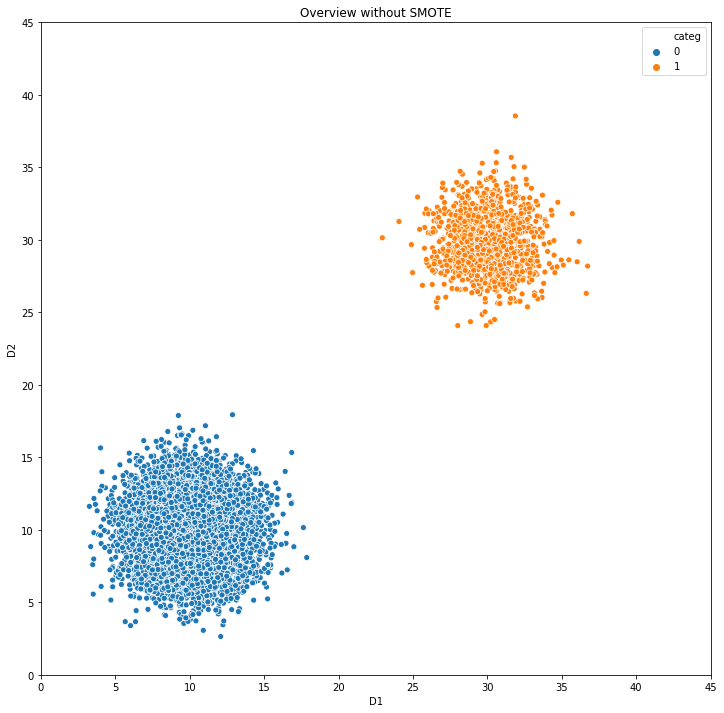

In [64]:
plt.figure(figsize=(12,12))
plt.title('Overview without SMOTE')
plt.xlim((0,45))
plt.ylim((0,45))
sns.scatterplot(overview1.D1,overview1.D2, hue=overview1.categ)

In [65]:
smote = SMOTE()

In [66]:
x_smote, y_smote = smote.fit_sample(overview1.drop(columns='categ'),overview1.categ)

In [71]:
y_smote.value_counts()

0    10000
1    10000
Name: categ, dtype: int64

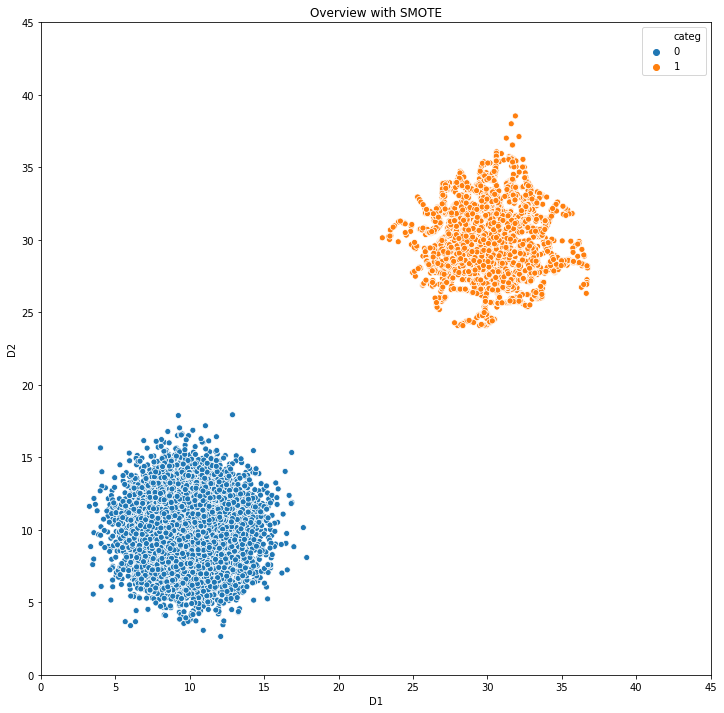

In [69]:
plt.figure(figsize=(12,12))
plt.title('Overview with SMOTE')
plt.xlim((0,45))
plt.ylim((0,45))
sns.scatterplot(x_smote.D1,x_smote.D2, hue=y_smote)

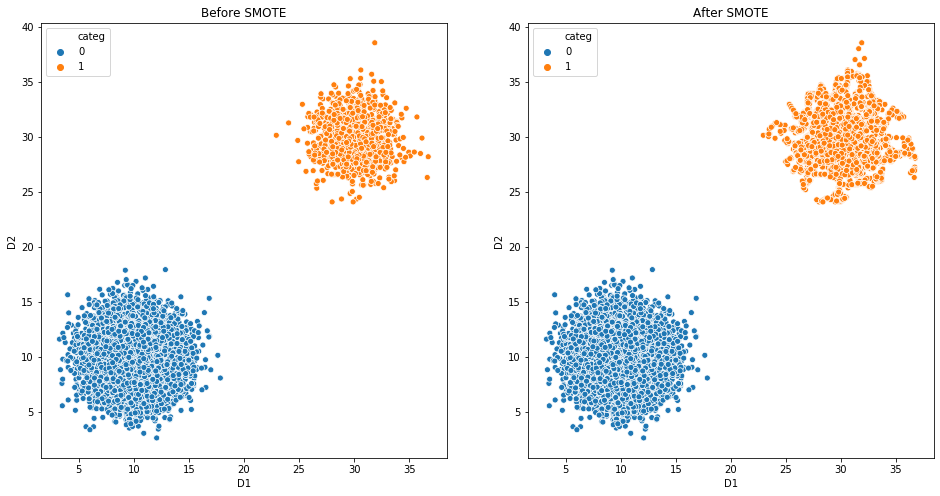

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))
ax1.set_title('Before SMOTE')
ax2.set_title('After SMOTE')
sns.scatterplot(overview1.D1,overview1.D2, hue=overview1.categ,ax=ax1)
sns.scatterplot(x_smote.D1,x_smote.D2, hue=y_smote,ax=ax2)
ax1.legend(loc=2)
ax2.legend(loc=2)

Here we can see the limits of SMOTE : the global distribution was not retrieved, here the new created points are just using local distribution (neighbors)

### SMOTE Baseline method

In [27]:
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [28]:
std = StandardScaler()
scaled_train = std.fit_transform(X_smote)
scaled_val = std.transform(X_val)

In [29]:
parameters = {
              "min_samples_leaf":[1,3,5,7],
              "max_depth": [int(i) for i in np.linspace(5, 30, num = 4)],
              "max_features":['auto', 'sqrt']
             } 


params=ParameterGrid(parameters)

import time
print('Param Optimisation start\n________________')
print('{} Steps to be done'.format(len(params)))
now = time.asctime()
print(now,'\n')

best_score = 0
best_model = None
best_params = None
best_predi = None
count=0

for param in params:
    

    
    rdm = RandomForestClassifier(n_estimators= 200,
                                 min_samples_leaf=param['min_samples_leaf'],
                                 max_depth=param['max_depth'],
                                 max_features=param['max_features'])
    

    rdm.fit(scaled_train,y_smote)
    
    y_pred = rdm.predict(scaled_val)
    
    score = fbeta_score(y_val, y_pred, beta=3)
    
    if score > best_score:
        best_score = score
        best_model = rdm
        best_param = str(param)
        best_predi = y_pred
        
    
    if count % 10 == 0 : 
        print('Step {} done\n'.format(count))
        now = time.asctime()
        print(now,'\n')
        
    count+=1
    
    
#Write score in summary table
summary_imbalance.loc['SMOTE ','f_beta_score']=best_score

#Write the string form of the best params dict
summary_imbalance.loc['SMOTE ','best_param']=best_param
# summary_imbalance
models['SMOTE']= best_model

Param Optimisation start
________________
32 Steps to be done
Wed Nov 18 15:15:26 2020 

Step 0 done

Wed Nov 18 15:16:51 2020 

Step 10 done

Wed Nov 18 15:34:29 2020 

Step 20 done

Wed Nov 18 16:02:59 2020 

Step 30 done

Wed Nov 18 16:34:41 2020 



NameError: name 'models' is not defined

Text(0.5, 51.0, 'Predicted Label')

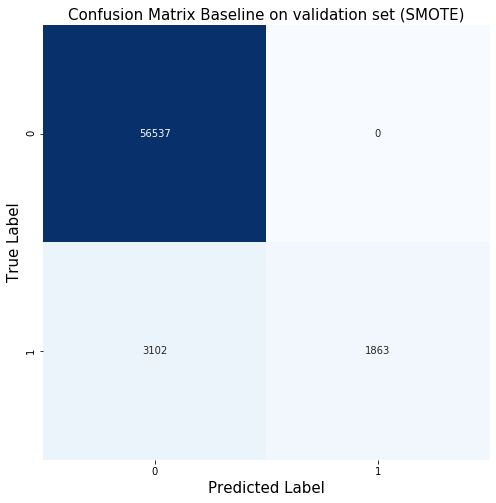

In [30]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      best_predi)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Baseline on validation set (SMOTE)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

### SMOTE with Threshold

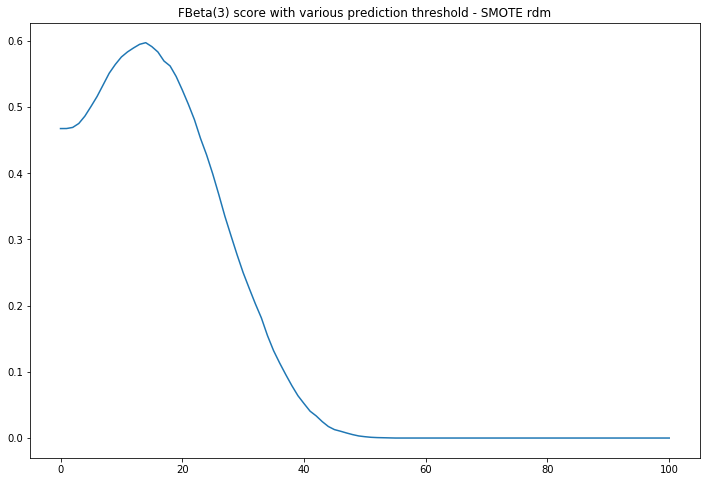

In [37]:
score_threshold=[]
predi = rdm.predict_proba(scaled_val)
for i in range(101):
    y_pred = (predi[:,1] >= i/100).astype(bool) # set threshold 
    score = fbeta_score(y_val, y_pred, beta=3)
    score_threshold.append(score)

plt.figure(figsize=(12,8))
plt.title('FBeta(3) score with various prediction threshold - SMOTE rdm')
sns.lineplot(list(range(101)),score_threshold)


In [38]:
threshold=[i for i, j in enumerate(score_threshold) if j == max(score_threshold)][-1]/100
threshold

0.14

In [40]:
max_predi = (rdm.predict_proba(scaled_val)[:,1] >=threshold) .astype(bool)

In [41]:
summary_imbalance.loc['SMOTE (Proba Threshold)','f_beta_score']=max(score_threshold)
my_param = eval(best_param)
my_param['threshold_proba']=threshold
summary_imbalance.loc['SMOTE (Proba Threshold)','best_param']=str(my_param)

Text(0.5, 51.0, 'Predicted Label')

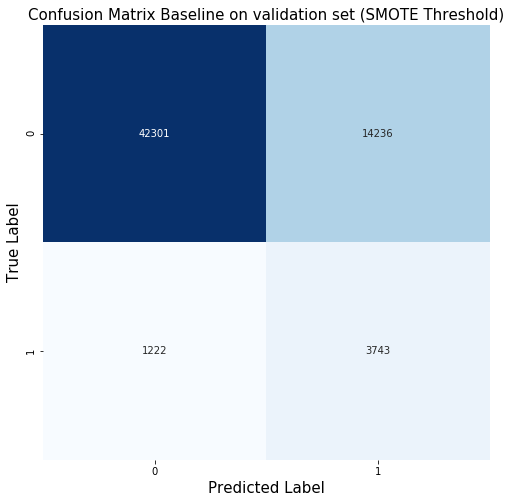

In [42]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      max_predi)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Baseline on validation set (SMOTE Threshold)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

In [43]:
summary_imbalance

,f_beta_score,best_param
Baseline,0.337953,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Baseline (Proba Threshold),0.607772,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Undersampling,0.598514,"{'max_depth': 30, 'max_features': 'sqrt', 'min..."
Undersampling (Proba Threshold),0.599223,"{'max_depth': 30, 'max_features': 'sqrt', 'min..."
SMOTE,0.397344,"{'max_depth': 30, 'max_features': 'sqrt', 'min..."
SMOTE (Proba Threshold),0.597313,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Class_Weight,0.507459,"{'max_depth': 17, 'max_features': 'sqrt', 'min..."
Class_Weight (Proba Threshold),0.608237,"{'max_depth': 17, 'max_features': 'sqrt', 'min..."
SMOTE,0.400232,"{'max_depth': 30, 'max_features': 'auto', 'min..."


## Class_Weight

In [362]:
ratio = y_train.value_counts().values[0]/y_train.value_counts().values[1]

In [364]:
ratio

11.3871

In [365]:
std = StandardScaler()
scaled_train = std.fit_transform(X_train)
scaled_val = std.transform(X_val)

In [376]:
parameters = {
              "min_samples_leaf":[1,3,5,7],
              "max_depth": [int(i) for i in np.linspace(5, 30, num = 4)],
              "max_features":['auto', 'sqrt']
             } 



params=ParameterGrid(parameters)

import time
print('Param Optimisation start\n________________')
print('{} Steps to be done'.format(len(params)))
now = time.asctime()
print(now,'\n')

best_score = 0
best_model = None
best_params = None
best_predi = None
count=0

for param in params:
    

    
    rdm = RandomForestClassifier(n_estimators= 200,
                                 min_samples_leaf=param['min_samples_leaf'],
                                 max_depth=param['max_depth'],
                                 max_features='sqrt')
    

    sample_weights_train = y_train.copy()
    sample_weights_train = np.where(sample_weights_train== 1, ratio, 1)

    
    rdm.fit(scaled_train,y_train,sample_weight=sample_weights_train)
    
    y_pred = rdm.predict(scaled_val)
    
    score = fbeta_score(y_val, y_pred, beta=3)
    
    if score > best_score:
        best_score = score
        best_model = rdm
        best_param = str(param)
        best_predi = y_pred
        
    
    if count % 10 == 0 : 
        print('Step {} done\n'.format(count))
        now = time.asctime()
        print(now,'\n')
        
    count+=1
    
    
#Write score in summary table
summary_imbalance.loc['Class_Weight ','f_beta_score']=best_score

#Write the string form of the best params dict
summary_imbalance.loc['Class_Weight ','best_param']=best_param
# summary_imbalance
models['Class_Weight']= best_model

Param Optimisation start
________________
32 Steps to be done
Tue Nov 17 12:55:14 2020 

Step 0 done

Tue Nov 17 12:55:37 2020 

Step 10 done

Tue Nov 17 13:01:17 2020 

Step 20 done

Tue Nov 17 13:13:18 2020 

Step 30 done

Tue Nov 17 13:28:01 2020 



Text(0.5, 51.0, 'Predicted Label')

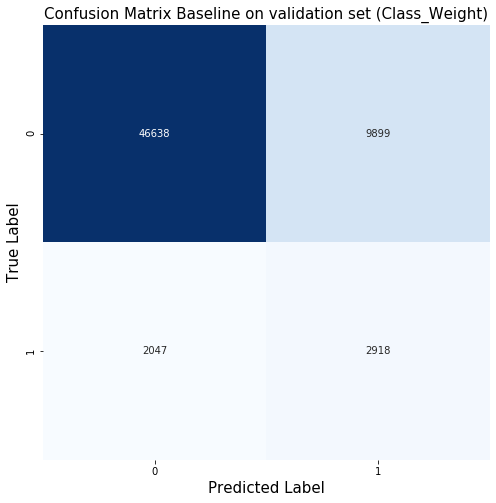

In [377]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      best_predi)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Baseline on validation set (Class_Weight)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

### Class_Weight With Threshold

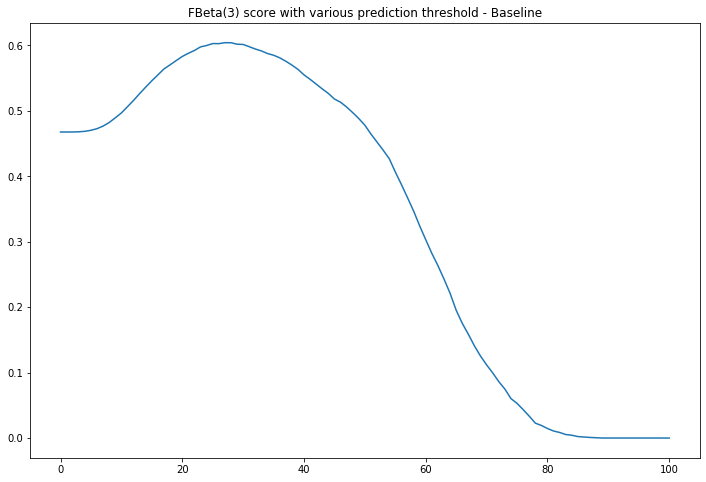

In [389]:
score_threshold=[]
predi = best_model.predict_proba(scaled_val)
for i in range(101):
    y_pred = (predi[:,1] >= i/100).astype(bool) # set threshold     score = fbeta_score(y_val, y_pred, beta=3)
    score_threshold.append(score)

plt.figure(figsize=(12,8))
plt.title('FBeta(3) score with various prediction threshold - Baseline')
sns.lineplot(list(range(101)),score_threshold)


In [445]:
threshold=[i for i, j in enumerate(score_threshold) if j == max(score_threshold)][-1]/100
print('max threshold: {}'.format(threshold))

max threshold: 0.27


In [380]:
max_predi = (best_model.predict_proba(scaled_val)[:,1] >=threshold) .astype(bool)

In [381]:
summary_imbalance.loc['Class_Weight (Proba Threshold)','f_beta_score']=max(score_threshold)
my_param = eval(best_param)
my_param['threshold_proba']=threshold
summary_imbalance.loc['Class_Weight (Proba Threshold)','best_param']=str(my_param)

In [505]:
summary_imbalance.iloc[5,1]

"{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'threshold_proba': 0.12}"

Text(0.5, 51.0, 'Predicted Label')

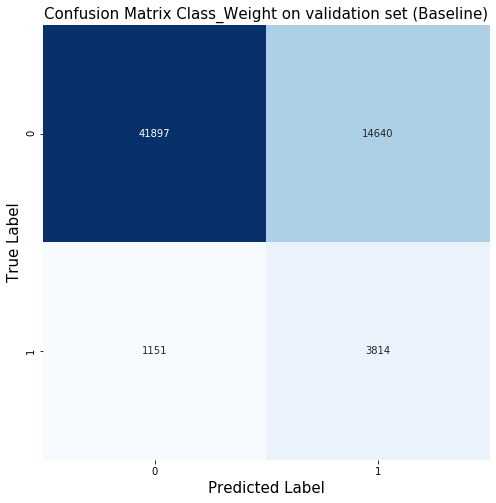

In [394]:
# Print Confusion Matrix 

cm = confusion_matrix(y_val,
                      max_predi)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Class_Weight on validation set (Baseline)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

# Results

In [48]:
summary_imbalance

,f_beta_score,best_param
Baseline,0.337953,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Baseline (Proba Threshold),0.607772,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Undersampling,0.598514,"{'max_depth': 30, 'max_features': 'sqrt', 'min..."
Undersampling (Proba Threshold),0.599223,"{'max_depth': 30, 'max_features': 'sqrt', 'min..."
SMOTE,0.400232,"{'max_depth': 30, 'max_features': 'auto', 'min..."
SMOTE (Proba Threshold),0.597313,"{'max_depth': 30, 'max_features': 'auto', 'min..."
Class_Weight,0.507459,"{'max_depth': 17, 'max_features': 'sqrt', 'min..."
Class_Weight (Proba Threshold),0.608237,"{'max_depth': 17, 'max_features': 'sqrt', 'min..."


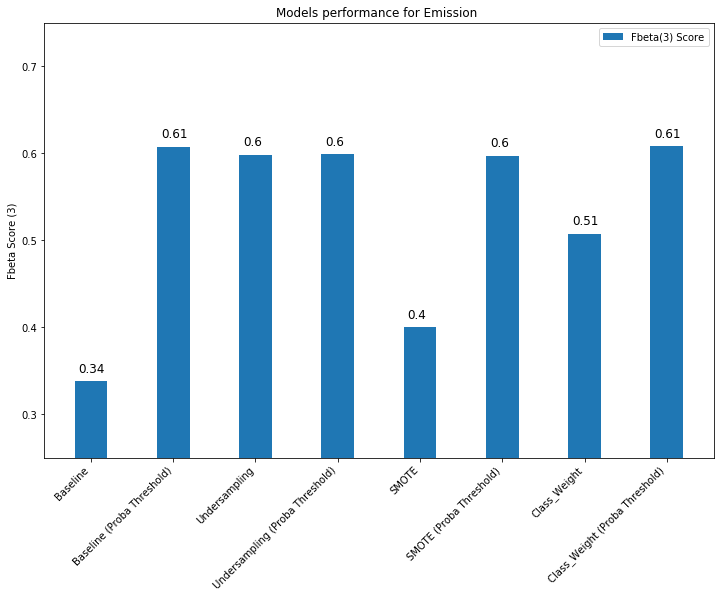

In [49]:
# Plot all the results for each methods
_X = np.arange(len(summary_imbalance.index))

fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111)

ax.set_title('Models performance for Emission ')
ax.bar(_X,summary_imbalance['f_beta_score'], 0.4,label='Fbeta(3) Score')
ax.legend()
ax.set_xticks(_X)
# ax.set_ylim([0.3,0.8])
ax.set_xticklabels(summary_imbalance.index, rotation=45, horizontalalignment='right')
ax.set_ylim([0.25,0.75])

for index, value in enumerate(summary_imbalance['f_beta_score']):
    val = np.around(value,2)   
    plt.text(index-0.15, value+0.01, str(val),fontsize=12)
plt.ylabel('Fbeta Score (3)')
    
plt.show()

## Test Score

In [ ]:
# Test score with the best model (final one)

In [510]:
y_test = np.array(test.TARGET)
test.drop(['TARGET'], axis = 1, inplace = True)
X_test = test.values

In [511]:
X_test_scale = std.transform(X_test)

In [522]:
final_class = models['Class_Weight']

In [523]:
th = summary_imbalance.iloc[7,1]['proba_threshold']

In [524]:
y_predi_test = (final_class.predict_proba(X_test_scale)[:,1] >=th).astype(bool)


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass beta=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


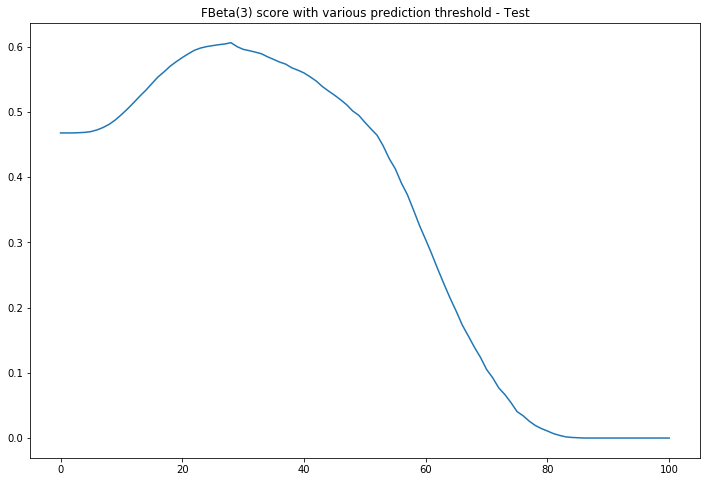

In [525]:
score_threshold=[]
predi = final_class.predict_proba(X_test_scale)
for i in range(101):
    y_pred = (predi[:,1] >= i/100).astype(bool) # set threshold     score = fbeta_score(y_val, y_pred, beta=3)
    score = fbeta_score(y_test,y_pred,3)
    score_threshold.append(score)

plt.figure(figsize=(12,8))
plt.title('FBeta(3) score with various prediction threshold - Test')
sns.lineplot(list(range(101)),score_threshold)


C:\Users\quent\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass beta=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


fbeta(3): 0.6039323621063288
auc score: 0.7543488810936878


Text(0.5, 51.0, 'Predicted Label')

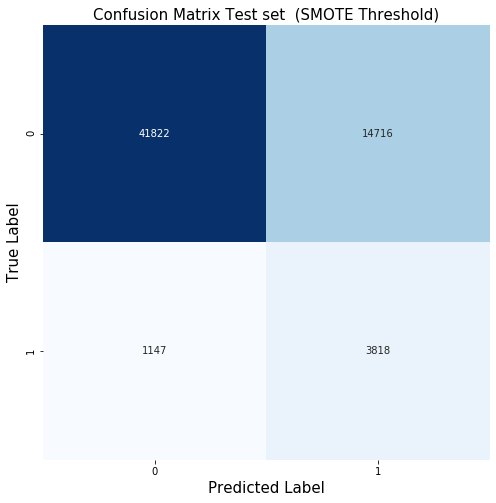

In [526]:
# Print Confusion Matrix 
fbeta= fbeta_score(y_test,y_predi_test,3)
auc= roc_auc_score(y_test,y_predi_test)
print('fbeta(3): {}\nauc score: {}'.format(fbeta,auc))

cm = confusion_matrix(y_test,
                      y_predi_test)

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix Test set  (SMOTE Threshold)',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g')
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

# Save Dashboard Resources

## Prediction

In [528]:
with open('dashboard_resources\model.pickle', 'wb') as file:
    pickle.dump(final_class, file)

In [529]:
with open('dashboard_resources\scaler.pickle', 'wb') as file:
    pickle.dump(std, file)

In [531]:
with open(r'dashboard_resources\threshold.pickle', 'wb') as file:
    pickle.dump(th, file)

## Customer Predicted 

In [ ]:
# Create a table with the customer prediction on the test data set (for the dashboard)

In [537]:
cust_pred = pd.DataFrame(test, columns=['SK_ID_CURR','TARGET'])
cust_pred['SK_ID_CURR']=cust_pred['SK_ID_CURR'].astype('int64')

In [543]:
cust_pred.TARGET.value_counts()

0.0    56538
1.0     4965
Name: TARGET, dtype: int64

In [544]:
cust_pred['proba'] = final_class.predict_proba(X_test_scale)[:,1]

In [97]:
cust_pred['predict']=(cust_pred['proba']>=th).astype(int)

In [111]:
cust_pred['TARGET']=cust_pred['TARGET'].astype(int)

In [112]:
cust_pred.head(50)

,SK_ID_CURR,TARGET,proba,predict
0,217687,0,0.151901,0
1,358891,0,0.144188,0
2,423598,0,0.083363,0
3,250825,0,0.256417,0
4,282856,0,0.112694,0
5,434684,0,0.285414,1
6,305158,0,0.151770,0
7,361245,0,0.187319,0
8,110480,0,0.168181,0
9,159675,0,0.274099,1


In [113]:
cust_pred.to_csv (r'C:/Users/quent/Desktop/Formation_OCR/Projets/Projet_7/dashboard_resources/cust_pred.csv', index = False, header=True)

## Average values 

In [ ]:
# Create a dataframe with average values for all customers, default_customer, non_default customer, on each feature

In [552]:
data = pd.read_csv('test2.csv')

In [553]:
average = pd.DataFrame(columns=data.columns,index = ['mean_value','non_default_customer','default_customer'])

In [554]:
average

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
mean_value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
non_default_customer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default_customer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [555]:
for col in average.columns:
    average.loc['mean_value',col]=data[col].mean()
    average.loc['non_default_customer',col]=data[data['TARGET']==0][col].mean()
    average.loc['default_customer',col]=data[data['TARGET']==1][col].mean()

In [557]:
average = average.T
average

,mean_value,non_default_customer,default_customer
SK_ID_CURR,278974,279132,277176
NAME_CONTRACT_TYPE,0.0948246,0.0971559,0.0682779
FLAG_OWN_CAR,0.338309,0.341929,0.29708
FLAG_OWN_REALTY,0.693316,0.694489,0.67996
CNT_CHILDREN,0.417362,0.413722,0.458812
...,...,...,...
WALLSMATERIAL_MODE_Wooden,0.0171374,0.0170151,0.0185297
EMERGENCYSTATE_MODE_No,0.516381,0.522286,0.449144
EMERGENCYSTATE_MODE_Yes,0.00757687,0.00749938,0.00845921
TARGET,0.0807278,0,1


In [126]:
average.to_csv (r'C:/Users/quent/Desktop/Formation_OCR/Projets/Projet_7/dashboard_resources/average.csv', index = True, header=True)

# Interpretability

## SHAP

In [ ]:
# Use SHAP to get the most important features used on our model 

In [68]:
import shap

In [69]:
shap.initjs()

In [77]:
x_val_shap = pd.DataFrame(scaled_val,columns=val.columns)
x_val_shap

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,-0.181718,-0.322808,-0.715527,-1.504575,2.187927,-0.226764,-0.816602,-0.915295,-0.724809,-1.001387,...,-0.175958,-0.08813,-0.075217,-0.072774,-0.522536,-0.514773,-0.133379,-1.033839,-0.088224,-0.469531
1,0.811560,-0.322808,1.397572,0.664640,2.187927,-0.097419,-0.197130,-0.343844,-0.199724,-0.129623,...,-0.175958,-0.08813,-0.075217,-0.072774,-0.522536,-0.514773,-0.133379,-1.033839,-0.088224,-0.469531
2,-1.466409,-0.322808,-0.715527,-1.504575,-0.576797,0.937340,1.942292,1.750549,2.279165,0.841649,...,-0.175958,-0.08813,-0.075217,-0.072774,1.913745,-0.514773,-0.133379,0.967268,-0.088224,-0.469531
3,1.723795,3.097819,1.397572,0.664640,2.187927,-0.123288,-0.816602,-0.934776,-0.724809,-0.885571,...,-0.175958,-0.08813,-0.075217,-0.072774,-0.522536,-0.514773,-0.133379,-1.033839,-0.088224,-0.469531
4,1.496988,-0.322808,1.397572,0.664640,-0.576797,0.031926,1.063259,0.204415,0.862657,1.074798,...,-0.175958,-0.08813,-0.075217,-0.072774,1.913745,-0.514773,-0.133379,0.967268,-0.088224,-0.469531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61497,-0.167974,-0.322808,-0.715527,0.664640,-0.576797,0.031926,-0.736336,-0.938796,-0.834711,-0.834409,...,-0.175958,-0.08813,-0.075217,-0.072774,-0.522536,1.942602,-0.133379,0.967268,-0.088224,-0.469531
61498,0.211256,-0.322808,-0.715527,0.664640,0.805565,-0.142690,-0.854733,0.223587,-0.846922,-0.834409,...,-0.175958,-0.08813,-0.075217,-0.072774,-0.522536,-0.514773,7.497410,0.967268,-0.088224,-0.469531
61499,-0.154931,-0.322808,-0.715527,0.664640,-0.576797,-0.097419,0.753500,0.590330,0.984770,0.396495,...,-0.175958,-0.08813,-0.075217,-0.072774,-0.522536,1.942602,-0.133379,0.967268,-0.088224,2.129785
61500,-1.075544,-0.322808,-0.715527,-1.504575,0.805565,0.031926,-0.037114,0.260076,0.007867,-0.087193,...,-0.175958,-0.08813,-0.075217,-0.072774,1.913745,-0.514773,-0.133379,0.967268,-0.088224,-0.469531


In [78]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(x_val_shap)

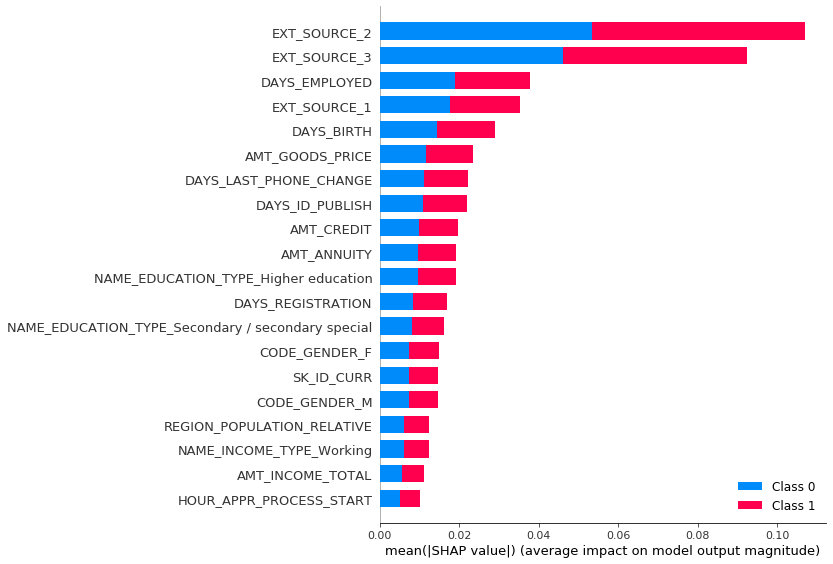

In [79]:
shap.summary_plot(shap_values,x_val_shap)

In [80]:
# To be tested
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(x_val_shap.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
32,EXT_SOURCE_2,3287.695020
33,EXT_SOURCE_3,2838.095342
11,DAYS_EMPLOYED,1160.552051
31,EXT_SOURCE_1,1083.355800
10,DAYS_BIRTH,893.141369


In [84]:
shap_features = feature_importance.col_name.values.tolist()

In [85]:
with open(r'dashboard_resources\shap_features.pickle', 'wb') as file:
    pickle.dump(shap_features, file)

In [86]:
with open(r'dashboard_resources\explainer.pickle', 'wb') as file:
    pickle.dump(explainer, file)

## View features importances 

In [54]:
with open('dashboard_resources\model.pickle', 'rb') as file:
        final_model=pickle.load(file)

In [57]:
# Create a dataframe which concatenates the feature name of the train and the coef feature attribute of our model
coef_features = final_model.feature_importances_
study_feature = pd.concat((pd.DataFrame(train.columns,columns=['Feature_name']),
                           pd.DataFrame(coef_features,columns=['Coef_feature'])),axis=1).sort_values(by='Coef_feature',ascending=False)
study_feature.head(10)

,Feature_name,Coef_feature
32,EXT_SOURCE_2,0.085650
33,EXT_SOURCE_3,0.081917
11,DAYS_EMPLOYED,0.036764
10,DAYS_BIRTH,0.035584
31,EXT_SOURCE_1,0.033878
13,DAYS_ID_PUBLISH,0.031890
6,AMT_CREDIT,0.030590
7,AMT_ANNUITY,0.030396
81,DAYS_LAST_PHONE_CHANGE,0.030129
12,DAYS_REGISTRATION,0.029235


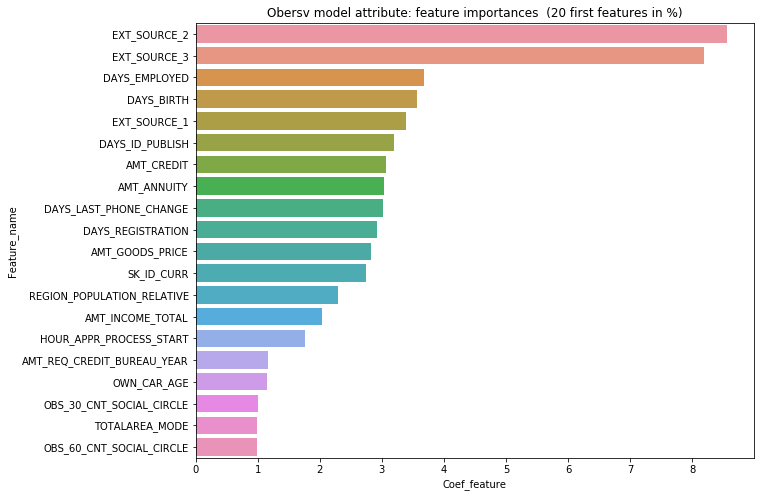

In [58]:
nbfeature=20

plt.figure(figsize=[10,8])
plt.title('Obersv model attribute: feature importances  ({} first features in %)'.format(nbfeature))
sns.barplot(x=(study_feature['Coef_feature']*100).head(nbfeature),y=study_feature['Feature_name'].head(nbfeature))

In [62]:
features_mvp = study_feature['Feature_name'].head(10).values.tolist()

In [64]:
with open(r'dashboard_resources\features_mvp.pickle', 'wb') as file:
    pickle.dump(features_mvp, file)

In [90]:
shap_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'AMT_GOODS_PRICE',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_EDUCATION_TYPE_Higher education',
 'DAYS_REGISTRATION',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'CODE_GENDER_F',
 'SK_ID_CURR',
 'CODE_GENDER_M',
 'REGION_POPULATION_RELATIVE',
 'NAME_INCOME_TYPE_Working',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_3',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'LIVINGAREA_AVG',
 'TOTALAREA_MODE',
 'LIVINGAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'REG_CITY_NOT_WORK_CITY',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DAYS_EMPLOYED_ANOM',
 'YEARS_BEGINEXPLUATATION_MODE',
 'APARTMENTS_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'APARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_AVG',
 'LANDAREA_MEDI',
 'BASEMENTAREA_AVG',
 'LANDAREA_MODE',
